# Reading and displaying medical 3D images

In [1]:
# export
# default_exp basics
import SimpleITK as sitk
import re
import pathlib
import torchvision
from fastai.basics import *

```python
print(sitk.Version())
for name, val in globals().items():
    if isinstance(val, types.ModuleType):
        try: 
            print(val.__name__ + ': ' + val.__version__)
        except:
            pass
            
SimpleITK Version: 2.0.0rc3 (ITK 5.1)
Compiled: Aug 25 2020 15:43:37

re: 2.2.1
torchvision: 0.7.0
platform: 1.0.8
numpy: 1.19.1
csv: 1.0
json: 2.0.9
matplotlib: 3.3.1
requests: 2.24.0
yaml: 5.3.1
pandas: 1.1.1
scipy: 1.5.2
scipy.ndimage: 2.0
torch: 1.6.0
```

Fastai 2 provides support to read and display medical images using pydicom and pillow, however only 2D images can be read. Both fastai and pytorch do not provide supply for 3D images. Therefore custom functions need to be designed. 

### Create a DICOM base class

Fastai already provides PILDicom and TensorDicom. But I believe, since these objects are designed to handle 2D data, using then might lead to problems in later tasks. So a custom Tensor class will be created to be able to use some of the very handy fastai functions.  

`freqhist_bins` and `hist_scaled` are needed to for image normalization

The `retain_type` function from fast ai can be used, to retain the TensorDicom3D type.
```python
retain_type(t, typ = TensorDicom3D)
```

In [2]:
# hide
class TensorDicom3D(Tensor):
    "Base class for 3D Dicom Tensor. Inherits from `torch.Tensor`"

## Read medical 3D images

3D data is stored in a variety of data formats (DICOM, NIfTI, NRRD, Analyze, ...) which should be supported by the image loader. Also DICOM data is often stored as individual slices (DICOM series) and not as a volume. [SimpleITK](https://simpleitk.org/) is a powerfull library which can handle many data formats, including all of the above mentioned and many more. It will therefore be used to read the 3D volumes.  

In [3]:
# export
def read_medical_3d_image(fn: (pathlib.Path, str), div=None, return_scaled=False, return_normalized=False): 
    '''
    Opens a 3D medical file or DICOM series and returns a tensor
    
    Args: 
        fn: file name as string or pathlib.Path
        div: new max for rescaling pixel values. If None, pixels will be rescaled between 0 and 1. 
    '''
    
    if isinstance(fn, str): fn = Path(fn)
        
    if fn.is_dir(): 
        SeriesReader = sitk.ImageSeriesReader()
        dicom_names = SeriesReader.GetGDCMSeriesFileNames(str(fn))
        SeriesReader.SetFileNames(dicom_names)
        im = SeriesReader.Execute()
        im = sitk.Cast(im, sitk.sitkInt16)
    
    elif fn.is_file():
        im = sitk.ReadImage(str(fn), outputPixelType=sitk.sitkInt16)
    
    else:
        raise TypeError('the path "{}" is neither a valid directory nor a file'.format(str(fn)))
    
    t = tensor(sitk.GetArrayFromImage(im)).float()
    
    # the array should be the raw pixel values, so no negative values should appear.
    
    if div is not None: 
        t = t/float(div) # Rescales images between 0 and a new max.
    elif not return_normalized:
        t = t/t.max()  # Rescales images between 0 and 1
 
    t = TensorDicom3D(t)
    if return_scaled: t = t.hist_scaled()
        
    if return_normalized and div is None: t = normalize(t)  # should only be executed if no specific max has been defined
        
    return retain_type(t, typ = TensorDicom3D)

## Display 3D images

Data visualisation is very important. Analogous to a radiology workstation it should be possible to display the images in axial, coronal or sagittal reformation. 

In [4]:
# export
def show_one_3d_image(t: (np.ndarray, Tensor), axis: int = 0, figsize: int = (15,15), cmap: str = 'bone', nrow: int = 10, return_grid = False, alpha = 1.):
    '''
    Plots 2D slices of a 3D image alongside a prior specified axis. 
    
    Args: 
        t: a 3D numpy.ndarray or torch.Tensor 
        axis: axis to split 3D array to 2D images
        figsize, cmap: passed to plt.imshow
        nrow: passed to torchvision.utils.make_grid
        return_grid: Whether the grid should be returned for further processing or if the plot should be displayed. 
        
    '''
    if t.ndim < 3 or t.ndim > 4: 
         raise TypeError('Object is not a rank 3 tensor but a rank {} tensor'.format(t.ndim))
    if t.ndim == 4: 
        warn('Object is not a rank 3 tensor but a rank {} tensor. Assuming the 4th dimension is a (fake) color channel it will be removed'.format(t.ndim))
        t = t[:,:,:,0]
        
    if isinstance(t, np.ndarray): t = tensor(t)
    
    if axis == 1: # is there a nicer, more flexible way?
        t = t.permute(1, 0, 2)
    elif axis == 2:
        t = t.permute(2, 0, 1)
        
    if t.min() < 0.: t = t-t.min() # shift pixelvalues to positive range, otherwise the negative values will be clipped. 
    
    t = t.unsqueeze(1)/torch.max(t) # rescale the images, makes for a nicer plot 
    grid = torchvision.utils.make_grid(t, nrow = nrow)
    if return_grid: return grid
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(grid, (1,2,0)), cmap = cmap, alpha = alpha)

(torch.Size([31, 736, 736]), None)

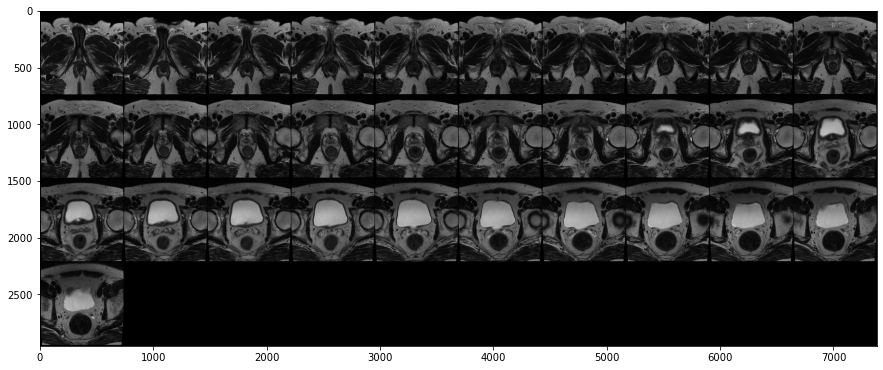

In [5]:
im = read_medical_3d_image('../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/DICOM')
im.shape, show_one_3d_image(im, axis = 0, nrow = 10)

Sometimes multiple 3D images (e.g. a batch) need to be displayed. With a wrapper for `show_one_3d_image` this is conveniently possible.  

In [6]:
# export
def show_multiple_3d_images(t_4d: Tensor, axis: int = 0, figsize: int = (15,15), cmap: str = 'bone', nrow: int = 10, alpha = 1., return_grid = False):
    "displays multiple 3D images (e.g. a batch) by flattening the 4th dimension of the tensor and then calling show_one_3d_image"
    
    if t_4d.ndim != 4: 
         raise TypeError('Object is not a rank 4 tensor but a rank {} tensor'.format(t_4d.ndim))
    
    if axis > 2: 
         raise ValueError('Axis should be between 0-2, indexing the plane to display each of the multiple 3D images. But axis was {}'.format(axis))
            
    grid_list = []
    n_images, _, _, _ = t_4d.shape
    for i in range(0, n_images): 
        grid_list.append(show_one_3d_image(t_4d[i,:,:,:], axis = axis,  nrow = nrow, return_grid = True))
    
    grid = torch.cat(grid_list, dim = 1)
    if return_grid: return grid
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(grid, (1,2,0)), cmap = cmap, alpha = alpha)
    

In [ ]:
show_multiple_3d_images(torch.stack((im,im)), axis = 0, nrow = 31, figsize = (25, 15))

## Crop and resize 3D images

Often the important areas of the images are also located centrally. For example in CT scans, the skin should always be included in the image, which means that the outer pixels will display only air or the scanner table. These areas can be cropped, effectivly reducing the size of the image without reducing the resolution. 

In [ ]:
# export
def crop_3d_tensor(t: Tensor, margins: (int, float), perc_margins = False):
    '''
    Often the regions of interest in the DICOM/NIfTI are centrally locaed in the image. 
    Cropping the margins substantially reduces image size, which makes it possible to keep a higher resolution in the relevant regions. 
    However, absolute cropping of pixel margins might be a problem with differen image resolutions for the same sequenze (e.g. T2 images can be 736x736 px or 448x448). 
     ropping the same margin for differen pixel resolutions could result in unwandet zooming effects. Cropping a percentage margin might be more beneficial.      
    
    Args: 
        t = torch Tensor object
        margins = a tuple of pixels to crop at both sides of each dimension. Either only one value for each dimension is given for a symmetrical crop or two values are given for asymmetric crop.
        perc_margins = whether the margins should be treated as absolute values or precentage values
    '''
    
    if type(margins) is tuple and len(margins) == 3:
        cropx, cropy, cropz = margins
        try: 
            if len(cropx) == 2:
                x1,x2 = cropx
            if len(cropx) == 2:
                y1,y2 = cropy
            if len(cropx) == 2:
                z1,z2 = cropz
        except:
            x1,x2,y1,y2,z1,z2 = cropx, cropx, cropy, cropy, cropz, cropz
            
    else:
        raise ValueError('"margins" must be a tuple with length 3, specifying the new (x,y,z) values of n Pixels to remove from the 3D tensor or representing percentages of pixels to remove from each margin')
    x, y, z = t.shape
    
    if perc_margins: 
        if not all(isinstance(i, float) for i in [x1,x2,y1,y2,z1,z2]): raise ValueError('percentage margins should be a float value between 0 and 0.5')
            
            
        x1,x2,y1,y2,z1,z2 = int(x1*x),int(x2*x),int(y1*y),int(y2*y),int(z1*z),int(z2*z)
    
    t = t[x1:x-x2, y1:y-y2, z1:z-z2]
    return retain_type(t, typ = TensorDicom3D) 

In [ ]:
cropped_im_abs = crop_3d_tensor(im, ((0,0),(100,100),(100,100)), perc_margins=False)
cropped_im_perc = crop_3d_tensor(im, ((0.,0.),(0.1,0.1),(0.1,0.1)), perc_margins=True)

im.shape, cropped_im_abs.shape, cropped_im_perc.shape

In [ ]:
show_one_3d_image(cropped_im_abs)

Medical data has different resolutions. Most CT scans will be at 512x512 px but for MRI the resolution varies. Also the number of slices is different for every scan. To train a neural network all input needs to be the same size, thus a function to resize the images alongside each axis is needed.

In [ ]:
# export
def resize_3d_tensor(t: Tensor, new_shape: int):
    
    '''
    A function to resize a 3D image using torch.nn.functional.grid_sample
    
    Taken form the offical documention: 
        Given an input and a flow-field grid, computes the output using input values and pixel locations from grid.
        In the spatial (4-D) case, for input with shape (N,C,Hin,Win) and with grid in shape (N, Hout, Wout, 2), the output will have shape (N, C, Hout,Wout)
        
        In the case of 5D inputs, grid[n, d, h, w] specifies the x, y, z pixel locations for interpolating output[n, :, d, h, w]. 
        mode argument specifies nearest or bilinear interpolation method to sample the input pixels.
        
    Workflow of this function: 
    1. create a fake RGB 3D image through generating fake color channels.
    2. add a 5th batch dimension
    3. create a flow-field for rescaling:
        a. create a 1D tensor giving a linear progression from -1 to 1
        b. creat a mesh-grid (the flow field) from x,y,z tensors from (a)
    4. resample the input tensor according to the flow field
    5. remove fake color channels and batch dim, returning only the 3D tensor
        
    Args:
        t (Tensor): a Rank 3 Tensor to be resized
        new_dim (int): a tuple with the new x,y,z dimensions of the tensor after resize
        
    '''
    if type(new_shape) is tuple and len(new_shape) == 3:
        z,x,y = new_shape # for a reason, I do currently not understand, order of the axis changes from resampling. flipping the order of x,y,z is the current workaround
    else:
        raise ValueError('"new_dim" must be a tuple with length 3, specifying the new (x,y,z) dimensions of the 3D tensor')
    
    t = torch.stack((t,t,t)) # create fake color channel
    t = t.unsqueeze(0).float() # create batch dim    

    x = torch.linspace(-1, 1, x) # create resampling 'directions' for pixels in each axis
    y = torch.linspace(-1, 1, y)
    z = torch.linspace(-1, 1, z)

    meshx, meshy, meshz = torch.meshgrid((x, y, z)) # 
    grid = torch.stack((meshy, meshx , meshz), 3) # create flow field. x and y need to be switched as otherwise the images are rotated. 
    grid = grid.unsqueeze(0) # add batch dim
    out = F.grid_sample(t, grid, align_corners=True, mode = 'bilinear') # rescale the 5D tensor
    out = out[0,0,:,:,:].permute(2,0,1).contiguous() # remove fake color channels and batch dim, reorder the image (the Z axis has moved to the back...)
    return retain_type(out, typ = TensorDicom3D)

In [ ]:
resized_im = resize_3d_tensor(im, (100,50,50))
resized_im.shape, show_one_3d_image(resized_im)

## Normalize images

Especially for MRI the pixel values can vary between scanner types. However, the imagenet stats, as provided by fastai should probably not be used, as they are specfic for color images and not MRI images. The optimal solution would probably be to calculate the stats on the present dataset. 

Statistics of intensity values, pooled across the whole training dataset (raw, unscaled pixel values and pixel values scaled between 0 and 1)

| Statistic                            | ADC       | T2          | T1 map   |
|--------------------------------------|-----------|-------------|----------|
| Pooled Maximum of intensity values   | 3064.2500 | 1369.5652   | 4095     |
| Pooled Minimum of intensity values   | 0.        | 0.          | 0.       |
| Pooled Mean of intensity values      | 511.1060  | 259.1454    | 740.8268 |
| Pooled SD of intensity values        | 488.8707  | 190.2448    | 688.8238 |
| Scaled Maximum of intensity values   | 1.        | 1.          | 1.       |
| Scaled Minimum of intensity values   | 0.        | 0.          | 0.       |
| Scaled Mean of intensity values      | 0.1675    | 0.1918      | 0.1809   |
| Scaled SD of intensity values        | 0.1599    | 0.1409      | 0.1682   |


However, just scaling wiht one mean and std might not be the optimal solution (see the excelent [Kaggle kernel](https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai) form Jeremy Howard why). Although for MRI images it might be ok, as the pixel values are closer together.

In [ ]:
im1 = resize_3d_tensor(read_medical_3d_image('../../dl-prostate-mapping/data/train/Gesund/A0042280702/T2/DICOM'), (10, 100, 100))
im2 = resize_3d_tensor(read_medical_3d_image('../../dl-prostate-mapping/data/train/Gesund/A0041912240/T2/DICOM'), (10, 100, 100))
im1.shape, im2.shape

In [ ]:
# export 
class TensorDicom3D(Tensor):
    "Base class for 3D Dicom Tensor. Inherits from `torch.Tensor`"
    
    def freqhist_bins(self:Tensor, n_bins=100):
        '''
        A function to split the range of pixel values into groups, such that each group has around the same number of pixels. 
        taken from https://github.com/fastai/fastai/blob/master/fastai/medical/imaging.py#L78
        '''
        imsd = self.view(-1).sort()[0]
        t = torch.cat([tensor([0.001]),
                       torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                       tensor([0.999])])
        t = (len(imsd)*t).long()
        return imsd[t].unique()

    def hist_scaled(self:Tensor, brks=None):
        '''
        Scales a tensor using `freqhist_bins` to values between 0 and 1
        taken from https://github.com/fastai/fastai/blob/master/fastai/medical/imaging.py#L78
        '''
        if self.device.type=='cuda': return self.hist_scaled_pt(brks)
        if brks is None: brks = self.freqhist_bins()
        ys = np.linspace(0., 1., len(brks))
        x = self.numpy().flatten()
        x = np.interp(x, brks.numpy(), ys)
        x = tensor(x).reshape(self.shape).clamp(0.,1.)
        return retain_type(x, typ = TensorDicom3D)

    @patch
    def hist_scaled_pt(self:Tensor, brks=None):
        # Pytorch-only version - switch to this if/when interp_1d can be optimized
        if brks is None: brks = self.freqhist_bins()
        brks = brks.to(self.device)
        ys = torch.linspace(0., 1., len(brks)).to(self.device)
        return self.flatten().interp_1d(brks, ys).reshape(self.shape).clamp(0.,1.)
    
    @classmethod
    def create(cls, fn:(Path,str,Tensor,ndarray), **kwargs)->None:
        "Open an `3D Image` from path `fn` or create it from an array"
        if isinstance(fn,ndarray): return cls(fn)
        if isinstance(fn, Tensor): return cls(fn)
        return cls(load_image_3d(fn))
    
    def show(self, axis: int = 0, figsize: int = (15,15), cmap: str = 'bone', nrow: int = 10):
        return show_one_3d_image(self, axis = axis, figsize=figsize, cmap=cmap, nrow=nrow, return_grid = False)


    
def load_image_3d(fn: (pathlib.Path, str)):
    if isinstance(fn, str): fn = Path(fn)
        
    if fn.is_dir(): 
        SeriesReader = sitk.ImageSeriesReader()
        dicom_names = SeriesReader.GetGDCMSeriesFileNames(str(fn))
        SeriesReader.SetFileNames(dicom_names)
        im = SeriesReader.Execute()
        im = sitk.Cast(im, sitk.sitkInt16)
    
    elif fn.is_file():
        im = sitk.ReadImage(str(fn), outputPixelType=sitk.sitkInt16)
    
    else:
        raise TypeError('the path "{}" is neither a valid directory nor a file'.format(str(fn)))
    
    return torch.tensor(sitk.GetArrayFromImage(im)).float()

Segmentations need an own class

In [ ]:
# export
class TensorMask3D(TensorDicom3D):
    "Base class for 3d Segmentation, inherits from TensorDicom3D"
    @classmethod
    def create(cls, fn:(Path,str,Tensor,ndarray), **kwargs)->None:
        "open the mask, scale back to int"
        if isinstance(fn,ndarray): return cls(fn)
        if isinstance(fn, Tensor): return cls(fn)
        return cls(load_image_3d(fn))

In [ ]:
import fastai.medical.imaging

In [ ]:
px1 = TensorDicom3D(im1.flatten())
plt.hist(px1.numpy(), bins = 40)
plt.hist(px1.hist_scaled().numpy(), bins = 40)
plt.title("Distribution of pixel values in T2 images original and scaled") 
plt.show()

The pixels are now all nearly equally distributed. 

In [ ]:
im1 = TensorDicom3D(im1)
im2 = TensorDicom3D(im2)

In [ ]:
show_multiple_3d_images(torch.stack((im1, im2, im1.hist_scaled(), im2.hist_scaled()), axis = 0), nrow = 10)

I belive both steps should executed after reading the images, even before cropping and resizing, thus they will be directly integrated into the `read_medical_3d_image` function. 

In [ ]:
#export
def normalize(t: Tensor):
    return (t - t.mean())/t.std()

In [ ]:
normalize(im).mean(), normalize(im).std()

In [ ]:
im = read_medical_3d_image('../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/DICOM', return_scaled=True, return_normalized=True)
im.shape, show_one_3d_image(im, axis = 0, nrow = 10)

In [ ]:
# nbdev_build_lib   